# Vision Transformer (ViT) using PyTorch (paper implementation)

In this project, I will implement the paper:  An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. The structure of this report will be as follows:

* Obtain the data
* Create Datasets and DataLoaders
* Understanding the ViT paper
* Implementing Patch Embedding
* Implementing Multi - Headed Attention/multi - head self - attention (MSA)
* Implementing Multilayer Perceptron (MLP)
* Bringing it all together
* Training and forming predictions

I will construct a Vision Transformer that solves the classification problem on a dataset called FoodVision Mini.

## Module processing for helpful functions

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Obtaining the data

The data is pre constructed images of pizza, steak and sushi.

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create the datasets and DataLoaders

Now that we have data, we need to turn them into DataLoaders. To do so we can use the create_dataloaders() function in data_setup.py. First, we'll create a transform to prepare our images.

In the figure below, we see the training resolution is mentioned in the paper as being 224 (height=224, width=224).

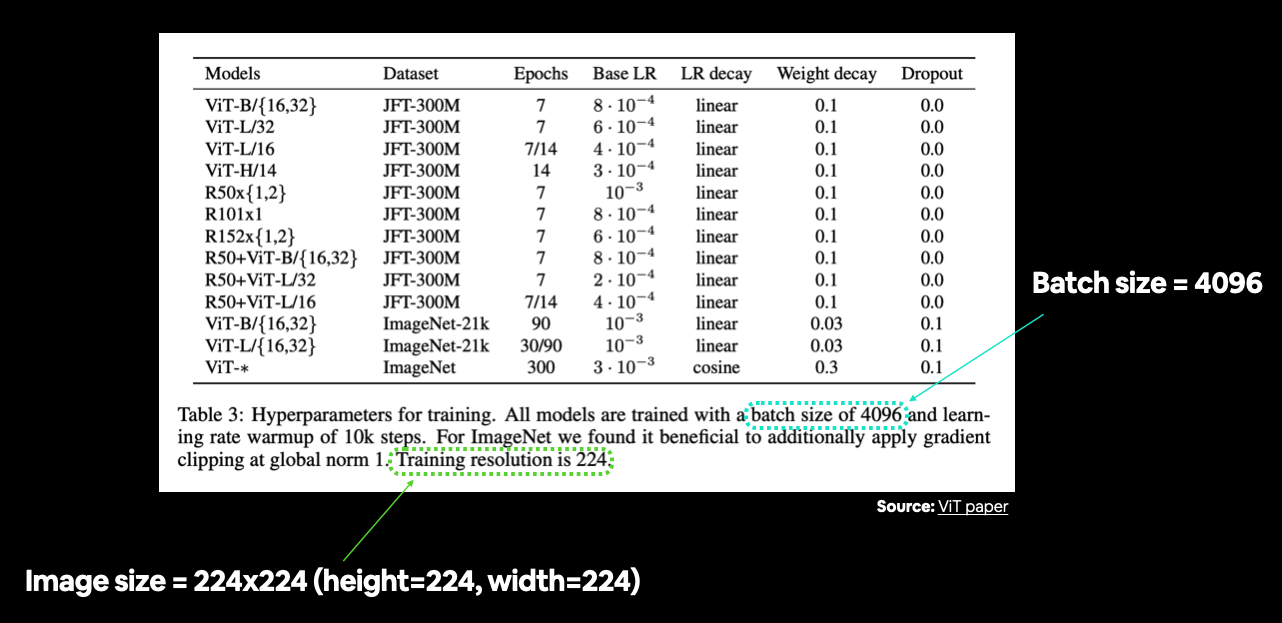

## Preparing the transformer for images

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## Turn the images into DataLoaders

The transformers have now been created. We now need to make the DataLoaders. The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32). We stick with using the batch size of 32 due to computational reasons.

An extension of this project could be to try a higher batch size value and see what happens.

In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26a06c22b80>,
 ['pizza', 'steak', 'sushi'])

## Visualising a single image

A key step in the original ViT paper is preparing the images into patches. To do so, we get a single image and label from a batch of data and inspect their shape

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

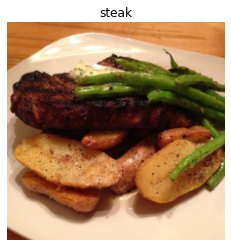

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Replicating the ViT paper (overview)

We would like to replicate the ViT paper for our own problem, FoodVision Mini. The model inputs are: images of pizza, steak and sushi. And our ideal model outputs are: predicted labels of pizza, steak or sushi.

### Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture, and generally, neural network architectures are made of layers. A collection of layers is referred to as a block. Stacking many blocks together is what gives us the whole architecture.

A layer takes an input (say an image tensor), performs some kind of action on it (for example what's in the layer's `forward()` method) and then returns an output. Therefore, I usually like to think of layers as functions. So if a single layer takes an input and gives an output, then a collection of layers or a block also takes an input and gives an output.

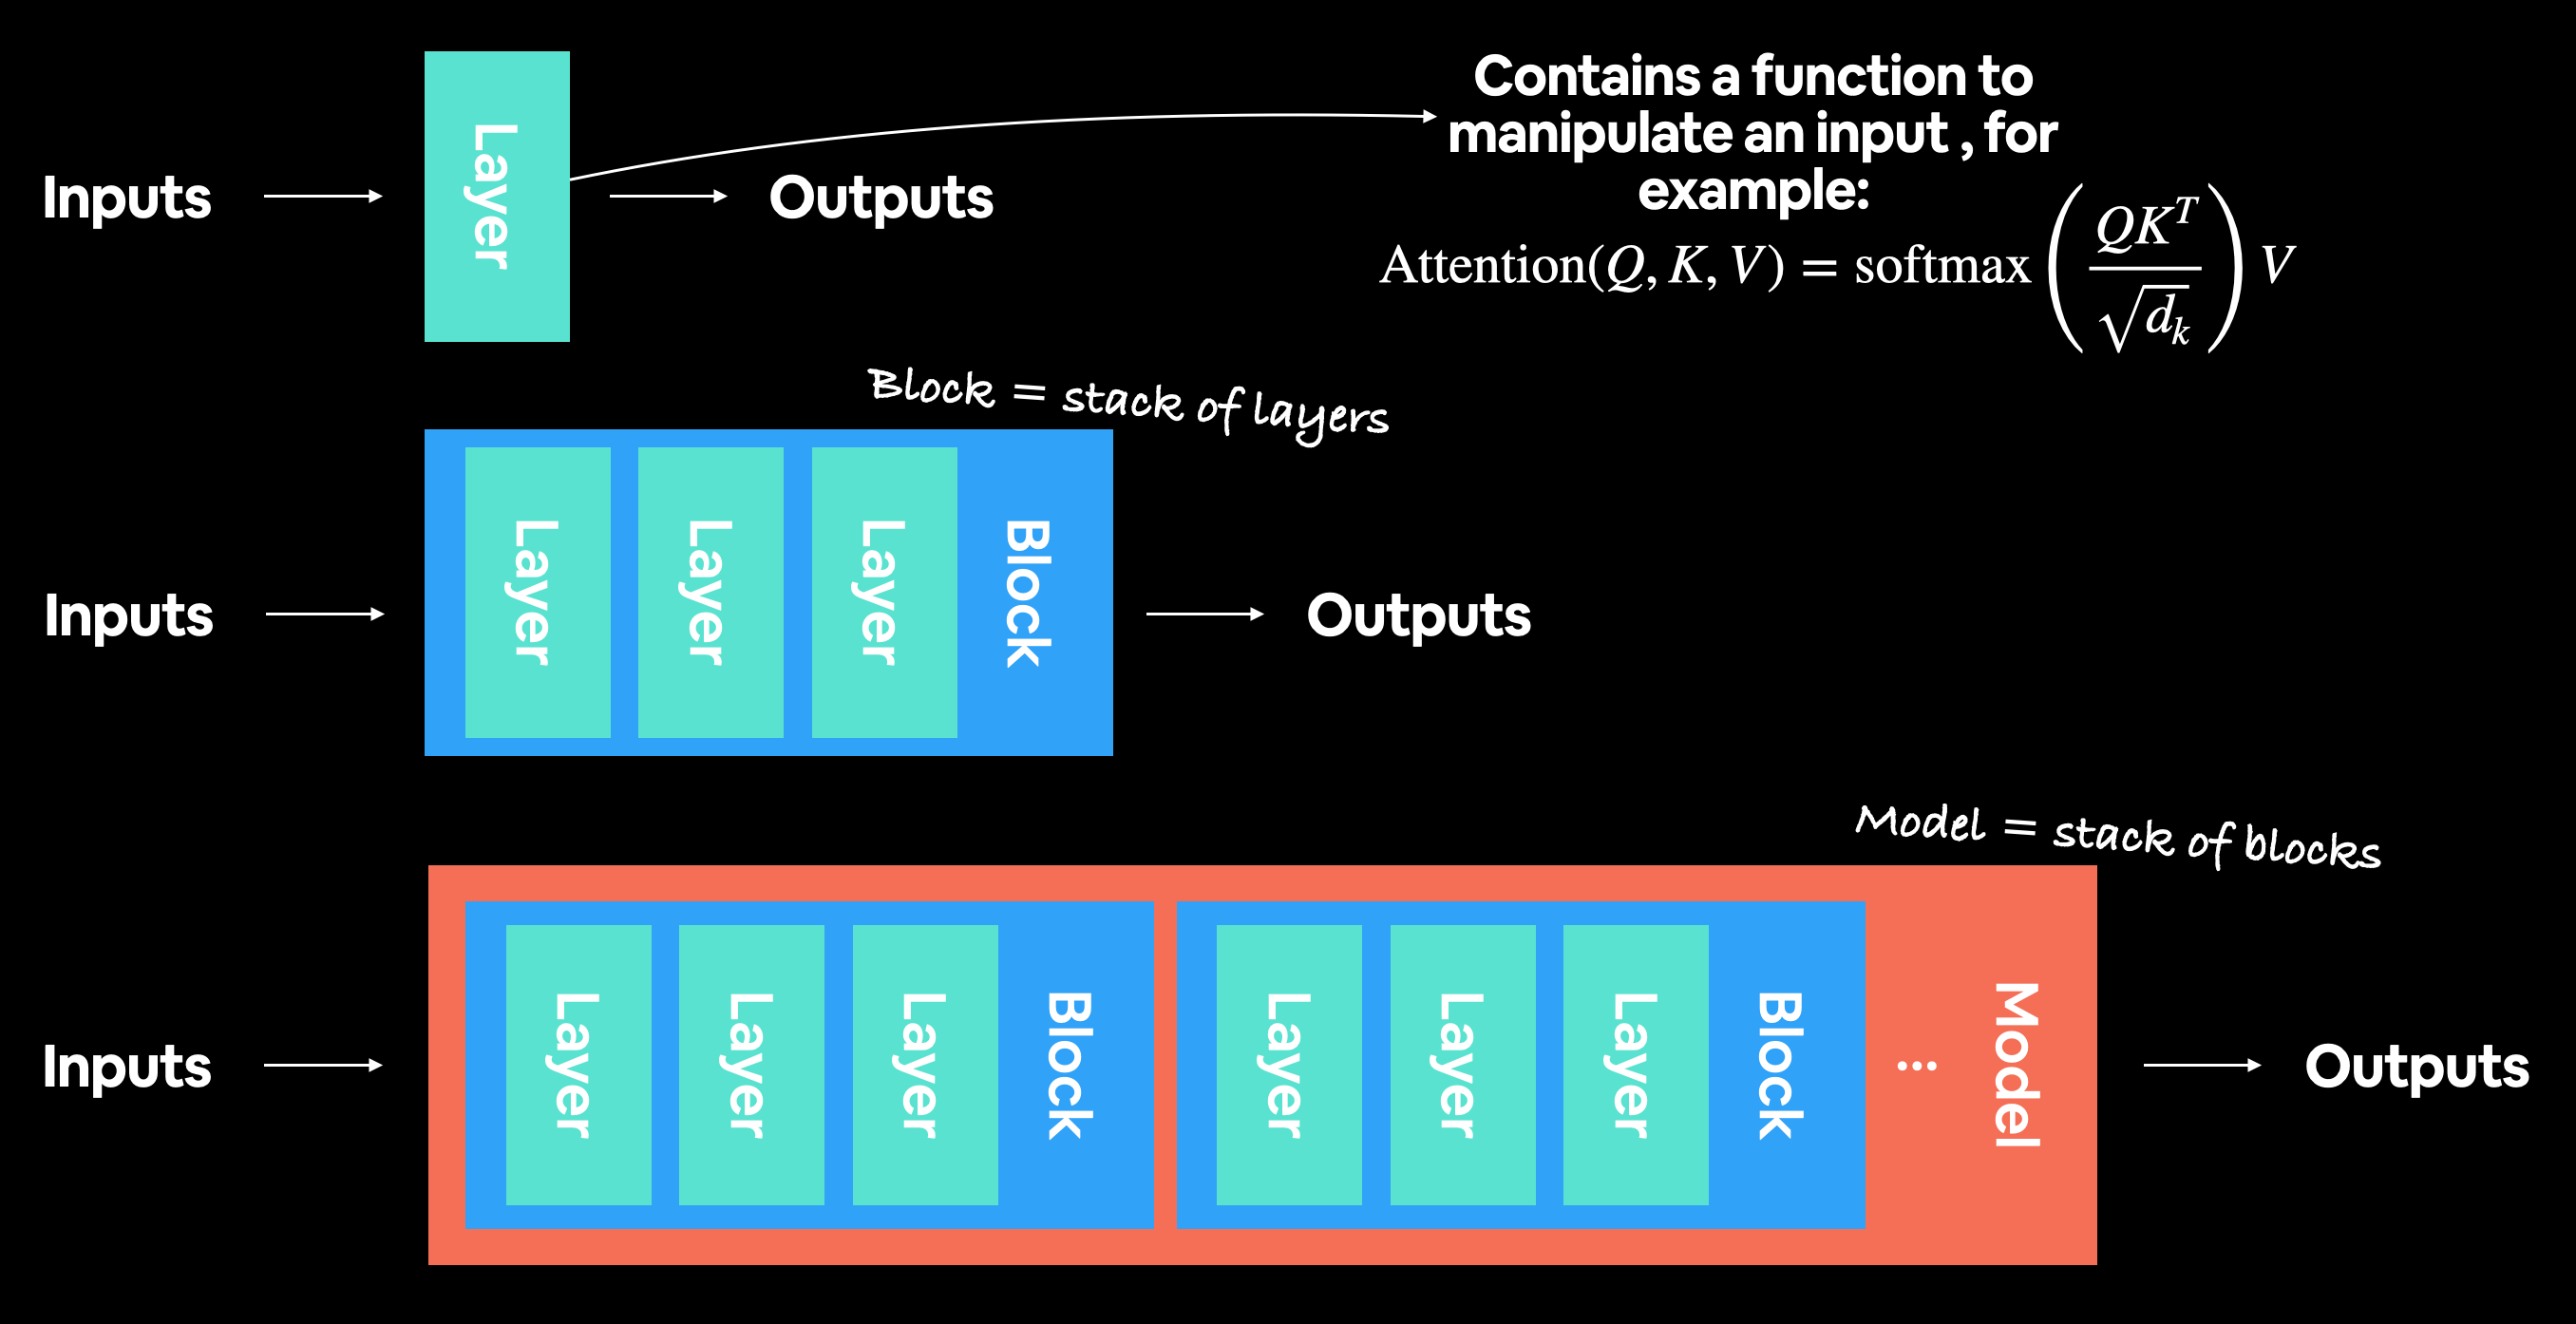

### Exploring the 4 main equations in the paper:

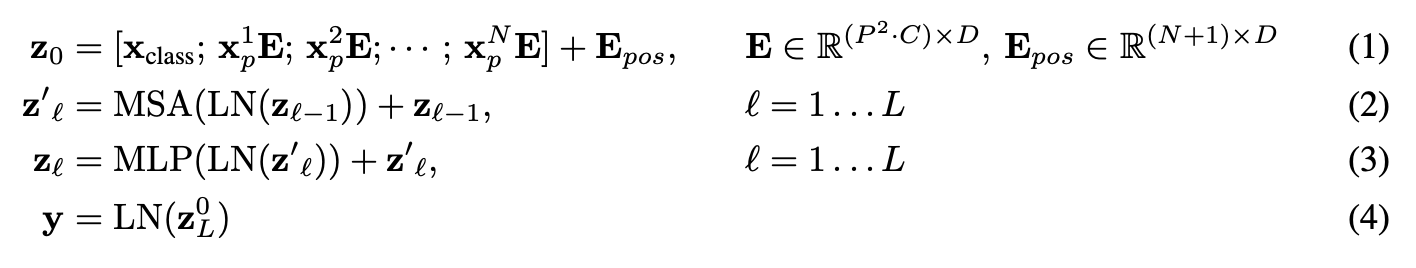

These four equations represent the maths behind the four major parts of the ViT architecture.

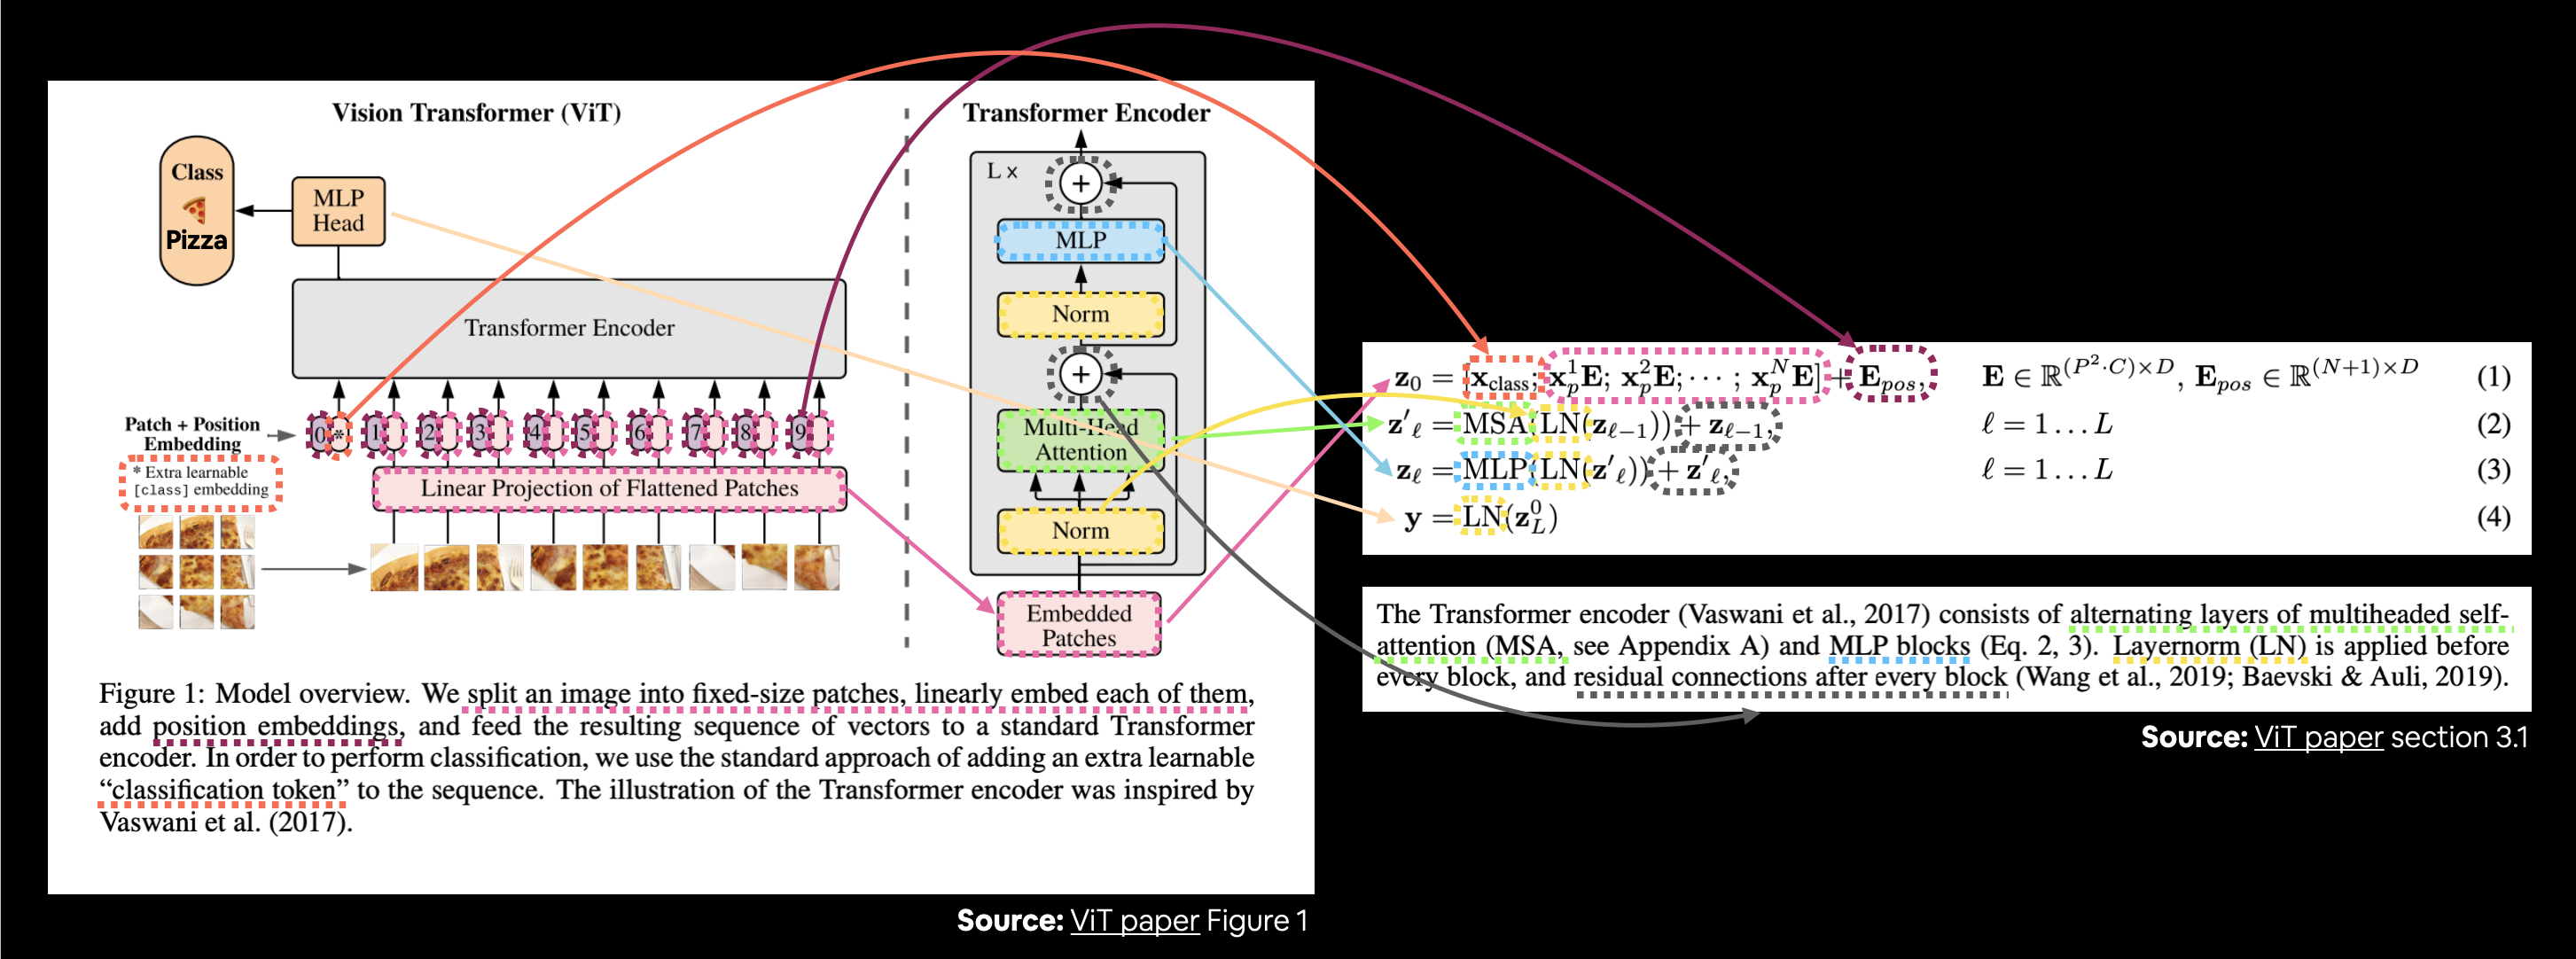

Connecting Figure 1 from the ViT paper to the four equations describing the maths behind each of the layers/blocks.

#### Exploring Table 1 from the paper

The final piece of the ViT architecture puzzle is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcases the various hyperparameters of each of the ViT architectures. The numbers gradually increase from ViT-Base to ViT-Huge. This project will focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. 

I use these values as the hyperparameter settings for our ViT architecture.

## Equation 1: Split data into patches and creating the class, position and patch embedding

I start by creating the class, position and patch embeddings for the ViT architecture. We'll start with the **patch embedding**.
This means I will be turning our input images in a sequence of patches and then embedding those patches. Recall that an **embedding** is a learnable representation of some form and is often a vector. The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And since we're dealing with image shapes, we keep in mind the line from Table 3 of the ViT paper:

> Training resolution is **224**.

The text above can be interpreted as:

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

## Calculating the patch embedding input and output shapes by hand

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.
We use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [9]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


We replicate the input and output shapes of the patch embedding layer.

Recall:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [10]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## Turning a single image into patches

We now know the input and output shapes for our **patch embedding** layer. It can now be constructed. We visualise a broken down image, visualising the top row of patches:

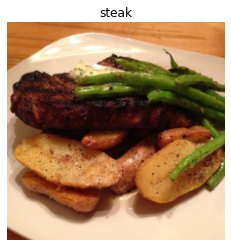

In [11]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

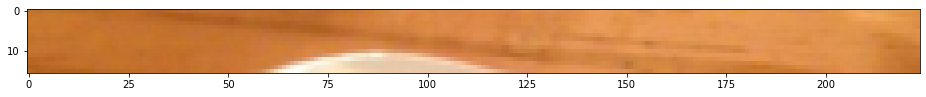

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Then we turn the top row into patches:

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


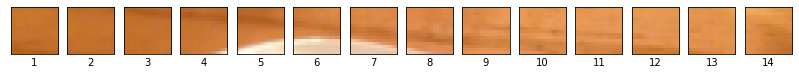

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

For the whole image:

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


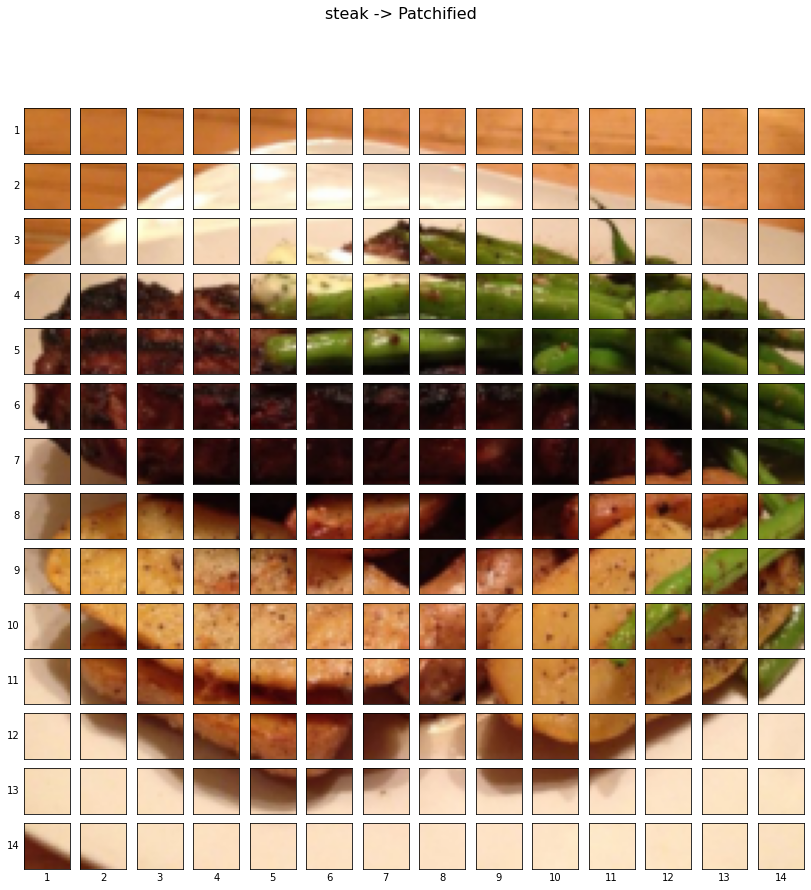

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Now we want to turn each of these patches into an embedding and convert them into a sequence.

## Creating image patches with `torch.nn.Conv2d()`

We have seen what an image looks like when it gets turned into patches, now let's start moving towards replicating the patch embedding layers with PyTorch.

Recall the folowing:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`. This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch). And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch). The kernel simply moves across the image.

We will set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [15]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

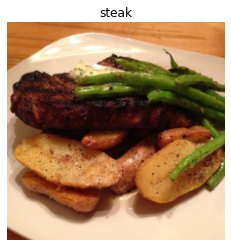

In [16]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [17]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing the image through the convolutional layer turns it into a series of 768 (this is the embedding size or $D$) feature/activation maps.

So its output shape can be read as:
    
```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

### Flattening the patch embedding with `torch.nn.Flatten()`

The images are now patch embeddings, but are still in 2D. We need to flatten them. In order to get them into the desired output shape of the patch embedding layer of the ViT model, we do the following. First recall:

* **Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

Check the current shape.

In [18]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


So far we have the 768 component. ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

Reading back through section 3.1 of the ViT paper it says:

> As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply *flattening* the spatial dimensions of the feature map and projecting to the Transformer dimension**.

To achieve this, we create a `torch.nn.Flatten()` layer to only flatten those dimensions, and we can use the `start_dim` and `end_dim` parameters to set that up.

In [19]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

So far, the steps are:

We:
1. Take a single image
2. Put in through the convolutional layer (`conv2d`) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence for further processing

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


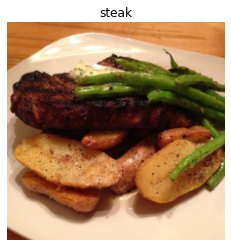

In [20]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

The `image_out_of_conv_flattened` shape is very close to our desired output shape:
    
* **Desired output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* **Current shape:** (1, 768, 196)

The only difference is our current shape has a batch size and the dimensions are in a different order to the desired output.

We need to re arrange the dimensions. We can do so with `torch.Tensor.permute()` just like we do when rearranging image tensors to plot them with matplotlib.

In [21]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


We have now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.

In [22]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-3.5600e-02, -3.4910e-02, -1.3048e-02, -5.9897e-03, -6.8366e-02,
          -6.5450e-02, -6.5838e-02, -2.7870e-02, -3.3463e-02, -6.0591e-02,
          -5.2574e-02, -5.3578e-02, -2.9467e-02, -6.1471e-02, -1.6693e-02,
          -2.0639e-02, -4.1503e-02, -1.5202e-01, -1.0920e-01, -1.5145e-01,
          -1.2668e-01, -1.1962e-01, -1.8640e-01, -1.6353e-01, -6.2753e-02,
          -9.6090e-02, -5.0796e-02, -5.3107e-02, -5.5765e-03, -1.2026e-01,
          -8.3983e-02, -6.8693e-02, -6.1057e-02, -8.7866e-02, -3.3769e-02,
          -9.7061e-02,  5.4097e-02, -1.0653e-01, -3.8292e-01, -6.8965e-02,
          -1.3577e-01, -1.6233e-01, -2.0160e-01, -4.8165e-02, -2.1371e-02,
          -5.3418e-03, -5.7324e-02, -1.3548e-01, -1.3536e-01, -1.3718e-01,
          -4.3266e-02, -1.6645e-01, -8.6502e-02, -7.8466e-03, -1.5569e-02,
          -3.1721e-02, -2.5978e-01, -5.3732e-03, -7.5784e-02,  3.2707e-03,
          -8.3975e-02, -1.0201e-01, -1.1542e-01, -1.3087e-01, -5.8994e-02,
          -7.1417e-02, -1

We have turned our single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattned Patches" in Figure 1 of the ViT paper).

### Turning the ViT patch embedding layer into a PyTorch module

We now put everything done so far for creating the patch embedding, into a single PyTorch layer. To do so, we subclass the `nn.Module` and create a small PyTorch "model" to do all of the steps above.

Specifically we'll:
1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

In [23]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

`PatchEmbedding` layer created. We can now try it out on a single image:

In [24]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
    
We have now replicated the patch embedding for equation 1.

### Creating the class token embedding

We now begin work on the  class token embedding.

Or $\mathbf{x}_\text {class }$ from equation 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png" width=900 alt="class token embedding highlight from the vision transformer paper figure 1 and section 3.1"/>

*Left: Figure 1 from the ViT paper with the "classification token" or `[class]` embedding token we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the learnable class embedding token.*

Reading the second paragraph of section 3.1 from the ViT paper, we see the following description:

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

So we need to "preprend a learnable embedding to the sequence of embedded patches".

We start by viewing our sequence of embedded patches tensor and its shape.

In [25]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5900,  0.0422, -0.0461,  ...,  0.3173, -0.3089,  0.2385],
         [-0.5926,  0.0470, -0.0700,  ...,  0.3061, -0.3014,  0.2403],
         [-0.6059,  0.0570, -0.0860,  ...,  0.3128, -0.2840,  0.2296],
         ...,
         [-0.9554,  0.2272, -0.2298,  ...,  0.6936, -0.4562,  0.3492],
         [-0.9486,  0.2227, -0.2332,  ...,  0.6822, -0.4469,  0.3536],
         [-0.9468,  0.2155, -0.2246,  ...,  0.6714, -0.4489,  0.3452]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the `embedding_dimension` ($D$) and then add it to the `number_of_patches` dimension.

Let us create a learnable embedding for the class token. To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`. Then, we make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [26]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [27]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5900,  0.0422, -0.0461,  ...,  0.3173, -0.3089,  0.2385],
         [-0.5926,  0.0470, -0.0700,  ...,  0.3061, -0.3014,  0.2403],
         ...,
         [-0.9554,  0.2272, -0.2298,  ...,  0.6936, -0.4562,  0.3492],
         [-0.9486,  0.2227, -0.2332,  ...,  0.6822, -0.4469,  0.3536],
         [-0.9468,  0.2155, -0.2246,  ...,  0.6714, -0.4489,  0.3452]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

We have got the class token embedding and the patch embedding, now we make the positional embedding.

Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width=900 alt="extracting the position embeddings from the vision transformer architecture and comparing them to other sections of the vision transformer paper"/>

*Left: Figure 1 from the ViT paper with the position embedding we will recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the position embedding.*

Let's find out more by reading section 3.1 of the ViT paper (bold mine):


To start creating the position embeddings, we can view the current embeddings:

In [28]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5900,  0.0422, -0.0461,  ...,  0.3173, -0.3089,  0.2385],
          [-0.5926,  0.0470, -0.0700,  ...,  0.3061, -0.3014,  0.2403],
          ...,
          [-0.9554,  0.2272, -0.2298,  ...,  0.6936, -0.4562,  0.3492],
          [-0.9486,  0.2227, -0.2332,  ...,  0.6822, -0.4469,  0.3536],
          [-0.9468,  0.2155, -0.2246,  ...,  0.6714, -0.4489,  0.3452]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where:
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1 (embedding dimension).

We have both of these values already, so we make a learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\text {pos }}$.

In [29]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note:** Only creating the position embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the position embedding with `torch.randn()` (start with a random number and improve via gradient descent).

We can incorporate the positional embedding into our existing structure with the token and the patch embeddings:

In [30]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4100, 1.0422, 0.9539,  ..., 1.3173, 0.6911, 1.2385],
         [0.4074, 1.0470, 0.9300,  ..., 1.3061, 0.6986, 1.2403],
         ...,
         [0.0446, 1.2272, 0.7702,  ..., 1.6936, 0.5438, 1.3492],
         [0.0514, 1.2227, 0.7668,  ..., 1.6822, 0.5531, 1.3536],
         [0.0532, 1.2155, 0.7754,  ..., 1.6714, 0.5511, 1.3452]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Image to embedding: the workflow

We have turned our input images into an embedding and replicated Equation 1 from Section 3.1 of the ViT paper:

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

Everything will now be joined together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can do so by:
1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer (the one we made in section 4.5) with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [31]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png" width=900 alt="mapping equation 1 from the vision transformer paper to pytorch code"/>

*Mapping equation 1 from the ViT paper to our PyTorch code.*

## Equation 2: Multi-Head Attention (MSA)

Our input data is patchified and embedded, now let's move onto the next part of the ViT architecture. To start, we'll break down the Transformer Encoder section into two parts.

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

We'll refer to equation 2 as the "MSA block".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

***Left:** Figure 1 from the ViT paper with Multi-Head Attention and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. **Right:** Mapping the Multi-Head Self Attention (MSA) layer, Norm layer and residual connection to their respective parts of equation 2 in the ViT paper.*


In saying this, to replicate these layers and residual connection with PyTorch code we can use:
* **Multi-Head Self Attention (MSA)** - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **Norm (LN or LayerNorm)** - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Residual connection** - add the input to output

### LayerNorm Layer

[Layer Normalization](https://paperswithcode.com/method/layer-normalization) (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

PyTorch's `torch.nn.LayerNorm()`'s main parameter is `normalized_shape` which we can set to be equal to the dimension size we'd like to noramlize over (in our case it'll be $D$ or `768` for ViT-Base).

### The Multi-Head Self Attention (MSA) layer

The power of the self-attention and multi-head attention (which is self-attention applied multiple times) were revealed in the form of the original Transformer architecture introduced in the [*Attention is all you need*](https://arxiv.org/abs/1706.03762) research paper.

You can find the formal defintion of the ViT paper's MSA implementation is defined in Appendix A:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png" alt="vision transformer paper figure 1 highlighted with equation 2 and appendix A" width=900/>

***Left:** Vision Transformer architecture overview from Figure 1 of the ViT paper. **Right:** Definitions of equation 2, section 3.1 and Appendix A of the ViT paper highlighted to reflect their respective parts in Figure 1.*

The image above highlights the triple embedding input to the MSA layer. This is known as **query, key, value** input or **qkv** for short which is fundamental to the self-attention mechanism.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* `batch_first` - does our batch dimension come first? (it does)

### Replicating Equation 2 with PyTorch layers

We now put everything we have discussed about the LayerNorm (LN) and Multi-Head Attention (MSA) layers in equation 2 into practice.

To do so, we'll:  

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module` (typically how we formed the blocks from earlier)
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate `embed_dim`, `num_heads`, `dropout` and `batch_first` parameters.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MSA layer.

In [32]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

The MSA block has been created. Let's try it out by creating an instance of our `MultiheadSelfAttentionBlock` and passing through the `patch_and_position_embedding` variable

In [33]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-in-code.png" width=900 alt="vision transformer paper with equation 2 of figure 1 highlighted and equation 2 turned into code"/>

***Left:** Vision Transformer architecture from Figure 1 with Multi-Head Attention and LayerNorm layers highlighted, these layers make up equation 2 from section 3.1 of the paper. **Right:** Replicating equation 2 (without the skip connection on the end) using PyTorch layers.*

We have now officially replicated equation 2 (except for the residual connection on the end but this will come later)

 ## Equation 3: Multilayer Perceptron (MLP)
 
 
We now replicate equation 3 in the following section:

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above). The addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder.

### The MLP layer(s)

Generally, MLP layers follow the pattern of:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

> The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers ([`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) and "GELU non-linearity" is the GELU  (Gaussian Error Linear Units) non-linear activation function ([`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) in PyTorch).

> **Note:** A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

> Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer ([`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) in PyTorch).

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, `dropout=0.1`).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size $D$ is the output size of the MLP block).

### Replicating Equation 3 with PyTorch layers

We now put everything we have discussed about the LayerNorm (LN) and MLP (MSA) layers in equation 3 into practice.

To do so, we'll:  

1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a sequential series of MLP layers(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [34]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

The MLPBlock class has now been created

Let us try it out by create an instance of our `MLPBlock` and passing through the `patched_image_through_msa_block`.

In [35]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


Notice how the input and output shape of our data again stays the same when it goes in and out of the MLP block.

## Create the Transformer Encoder

We now put together the `MultiheadSelfAttentionBlock` (equation 2) and `MLPBlock` (equation 3) and create the Transformer Encoder of the ViT architecture. We now need to incorporate the residual connections.
[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), were first introduced in the paper [*Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output, where the output might be one or more layers later.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block. The same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

In pseudocode:

`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

> **Note:** The iconic computer vision architecture "ResNet" is named so because of the introduction of *res*idual connections. You can find many pretrained versions of ResNet architectures in [`torchvision.models`](https://pytorch.org/vision/stable/models.html).

###  Creating a Transformer Encoder by combining our custom made layers

To do so, we'll:  

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our `MultiheadSelfAttentionBlock` with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our `MLPBlock` with the appropriate parameters.
5. Create a `forward()` method for our `TransformerEncoderBlock` class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [36]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [37]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

#### Creating a Transformer Encoder with PyTorch's Transformer layers

So far we have built the components of and the Transformer Encoder layer itself. But because of their rise in popularity and effectiveness, PyTorch now has in-built [Transformer layers as part of `torch.nn`](https://pytorch.org/docs/stable/nn.html#transformer-layers). For example, we can recreate the `TransformerEncoderBlock` we just created using [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and setting the same hyperparameters as above.

In [38]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

## Putting it all together to create ViT

We can now combine all our blocks to replicate the ViT architecture. We have not constructed equation 4 yet, but it can be incorporated into our overall ViT architecture class.

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$


All we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the target number of classes we have. To create the full architecture, we also stack a number of our `TransformerEncoderBlock`s on top of each other, we can do this by passing a list of them to `torch.nn.Sequential()` (this will make a sequential range of `TransformerEncoderBlock`s).

We'll focus on the ViT-Base hyperparameters from Table 1 but our code should be adaptable to other ViT variants.
The workflow is then to:

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=H W / P^{2}$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1)
6. Create a learnable position embedding vector (equation 1)
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class as above 
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`sto `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using [`torch.Tensor.expand()`](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. The Vision transformer is constructed!

In [39]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

We can demo showcase what's happening with the class token embedding being expanded over the batch dimensions.

In [40]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


We can  test out ViT() class. To do this, we create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens.

In [41]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## Setting up training code for ViT model

To train our model we can import the `train()` function from [`going_modular.going_modular.engine`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/train.py).

All we need is a loss function and an optimizer.

### Creating an optimizer

Searching the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:

> **Training & Fine-tuning.** We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

So we can see they chose to use the "Adam" optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)) rather than SGD (stochastic gradient descent, [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)).

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9, \beta_{2}=0.999$, these are the default values for the `betas` parameter in `torch.optim.Adam(betas=(0.9, 0.999))`.

They also state the use of [weight decay](https://paperswithcode.com/method/weight-decay) (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the `weight_decay` parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We choose to set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations.

## Using a pretrained ViT from `torchvision.models` on the same dataset

We can now use transfer learning, from a pre trained model.

###  Getting a pretrained ViT model and creating a feature extractor

We can get a pretrained ViT model from `torchvision.models`.

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Finally, we'll get the pretrained ViT-Base with patch size 16 from `torchvision.models` and prepare it for our FoodVision Mini use case by turning it into a feature extractor transfer learning model.

Specifically, we:
1. Get the pretrained weights for ViT-Base trained on ImageNet-1k from [`torchvision.models.ViT_B_16_Weights.DEFAULT`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights) (`DEFAULT` stands for best available).
2. Setup a ViT model instance via `torchvision.models.vit_b_16`, pass it the pretrained weights step 1 and send it to the target device.
3. Freeze all of the parameters in the base ViT model created in step 2 by setting their `requires_grad` attribute to `False`.
4. Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of `out_features` to our number of classes (pizza, steak, sushi).

In [43]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\media/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|███████████████████████████████████████████████████████████████████████████████| 330M/330M [00:43<00:00, 8.02MB/s]


### Preparing data for the pretrained ViT model

Let's download some image data (pizza, steak and sushi images for Food Vision Mini), setup train and test directories and then transform the images into tensors and DataLoaders.

In [46]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [47]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [48]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [49]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### Train feature extractor ViT model

In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]